In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%autosave 30

Autosaving every 30 seconds


In [3]:
from matplotlib import pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
import tensorflow as tf

style.use(['ggplot'])

# Bước 2: Load bộ dữ liệu NER

Sau khi đọc tập dữ liệu, chúng ta quan sát thử 50 dòng đầu tiên như thế nào.


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS310-NLTK/Buổi 2/ner_dataset.csv', encoding="latin1")
data = data.fillna(method="ffill")
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


#Visualizing 
Thông kê bộ dữ liệu:
- Số lượng từ duy nhất trong kho ngữ liệu. (Tập từ vựng, số chiều)
- Số lượng thẻ duy nhất trong tập dữ liệu. (Tập nhãn)


Bằng cách sử dụng hàm **“nunique”.**

In [5]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


Tạo một danh sách và sử dụng phương thức set() để lấy các giá trị trong cột “word” và loại bỏ giá trị trùng.\
Thêm phần đệm có tên “Endpad”.


In [6]:
# tạo tập từ vựng
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [7]:
# tạo tập nhãn tương tự
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [8]:
print(num_words, num_tags)

35179 17


# Bước 3: Lấy các câu và các thẻ tương ứng

In [9]:
def get_sentences(data):
  agg = lambda s: [(w,t) for w, t in zip(s["Word"].values.tolist(),
                                         s["Tag"].values.tolist())]
  group = data.groupby('Sentence #').apply(agg)
  return [sen for sen in group]

In [10]:
sentences = get_sentences(data)
sentences[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

# Bước 4: Ánh xạ giữa các câu và chỉ mục
Chúng ta có thể thấy rằng mỗi từ được gán cho một thẻ duy nhất. Chúng tôi có thể truy xuất những từ này bằng cách sử dụng các chỉ số của chúng và tra cứu chúng trong từ điển và trả về các khóa tương ứng.


In [11]:
word2idx = {w: i   for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [12]:
# word2idx
word2idx["ENDPAD"]
tag2idx

{'B-gpe': 0,
 'B-nat': 1,
 'B-eve': 2,
 'B-tim': 3,
 'B-art': 4,
 'B-geo': 5,
 'I-per': 6,
 'I-nat': 7,
 'B-per': 8,
 'B-org': 9,
 'I-org': 10,
 'O': 11,
 'I-gpe': 12,
 'I-art': 13,
 'I-eve': 14,
 'I-tim': 15,
 'I-geo': 16}

#Bước 5: Padding  đầu vào và cắt dữ liệu thành tập Train, Test
Trong trục X, có thể thấy độ dài an toàn của câu là khoảng 50.

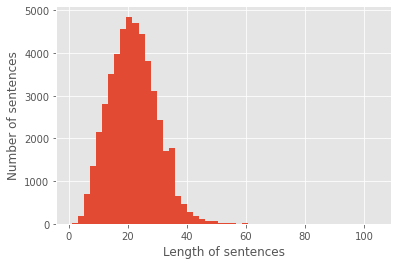

In [13]:
#vẽ biểu đồ thể hiện phân bố chiều dài của câu trong tập dữ liệu.
plt.hist([len(s) for s in sentences], bins=50)

plt.xlabel('Length of sentences')
plt.ylabel('Number of sentences')
plt.show()

- Sử dụng hàm pad_sequence() cho padding
- X sẽ là một đại diện bằng số cho các từ. (sử dụng word2idx)
- ‘Post’ chỉ là một giá trị của đối số đệm ở cuối câu.
- X,y là vector

In [14]:
#ánh xạ từ trong câu và nhãn về index của nó
from tensorflow.keras.preprocessing.sequence import pad_sequences
# đặt max length cho phù hợp
max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

#tương tự với nhãn
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"])


In [15]:
print(X[0])
print(y[0])

[ 4944 27203 24938  1986 31305  7983 29990 21224  5559  8670  1083 34768
 17989 32744  7960  8670   969 27203  5441 28216 25475  1870 10135 24489
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
[11 11 11 11 11 11  5 11 11 11 11 11  5 11 11 11 11 11  0 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11]


- test_size = 0.2 có nghĩa là 80% dữ liệu chia cho tập huấn luyện và 20% còn lại cho tập kiểm tra.

In [16]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Bước 6: Xây dựng Mô hình LSTM hai chiều (BI-LSTM)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

Bản tóm tắt cho thấy rằng chúng ta có hơn 1,8 triệu tham số cần được huấn luyện.

In [18]:
model = Sequential() #Yêu cầu khỏi tạo mạng LSTM 1 chiều

# Input
model.add(Input(shape=(max_len,)))

# Embedding
model.add(Embedding(input_dim=num_words, output_dim=50, input_length=50))

# SpatialDropout1D
model.add(SpatialDropout1D(0.1))

# LSTM
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))

# TimeDistributed
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                                 
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
______________________________________________

- Sử dụng trình tối ưu hoá "adam"
- sparce_categorical_crossentropy làm hàm mất mát
- Ma trận mà chúng ta sẽ quan tâm là ma trận độ chính xác.

In [19]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#Bước 7: Huấn luyện Model

- Để bắt đầu huấn luyện là gọi model.fit ()
- Có thể tăng kích thước batch_size nếu bạn có GPU có kích thước bộ nhớ lớn.



In [20]:
# Các bạn nhớ là phải lưu mô hình khi train (có nhắc lại yêu cầu ở cuối) 
import time
start_time = time.time()

history = model.fit(
    x=x_train,
    y=y_train,
    validation_split= 0.1,
    batch_size= 32, 
    epochs=1,
    verbose=1
)
print("[{}] Completed!".format(time.time() - start_time))

1080/1080 [==============================] - 263s 238ms/step - loss: 0.1900 - accuracy: 0.9561 - val_loss: 0.0708 - val_accuracy: 0.9801
[267.81624579429626] Completed!


# Bước 8: Đánh giá mô hình NER



In [21]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 13s 44ms/step - loss: 0.0739 - accuracy: 0.9795


[0.073877714574337, 0.9795100092887878]

- Dự đoán

In [22]:
# i = np.random.randint(0, x_test.shape[0]) #659
i = 10
p = model.predict(np.array([x_test[i]]))

p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 1s 591ms/step
Word           True 	 Pred

------------------------------
avian          O	O
cooperate      O	O
driver         O	O
ambassador-at-largeO	O
Morsink        O	O
refuge         B-geo	B-geo
innovation     O	O
Radio          O	O
innovation     O	O
1841           B-geo	B-geo
impossible     O	O
condemning     O	O
grievously     O	O
contracts      O	O
Nair           O	O
catheterizationO	O
65,000         O	O
gyroscopes     O	O
factors        O	O
guides         O	O
clemency       O	O
appealing      O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request        O	O
request      

# Hoàn thành yêu cầu trong file thực hành tương ứng với câu 1

## Thêm đánh giá mô hình theo độ đo F1

In [23]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)

300/300 [==============================] - 17s 55ms/step


In [24]:
from sklearn.metrics import f1_score, classification_report

print('micro:', f1_score(y_test.flatten(), y_pred.flatten(), average='micro')*100)
print('macro:', f1_score(y_test.flatten(), y_pred.flatten(), average='macro')*100)

micro: 97.95100083402836
macro: 45.004384181086174


## Xuất kết quả của F1 score và Accuracy theo từng nhãn thực thể

In [25]:
print(classification_report(y_test.flatten(), y_pred.flatten(), target_names = tags))
print('Accuracy:', model.evaluate(x_test, y_test)[1]*100)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-gpe       0.94      0.91      0.92      3173
       B-nat       0.00      0.00      0.00        38
       B-eve       0.00      0.00      0.00        79
       B-tim       0.89      0.79      0.83      4102
       B-art       0.00      0.00      0.00        96
       B-geo       0.77      0.86      0.81      7380
       I-per       0.81      0.82      0.81      3424
       I-nat       0.00      0.00      0.00        12
       B-per       0.81      0.71      0.76      3359
       B-org       0.69      0.49      0.57      3908
       I-org       0.63      0.71      0.67      3254
           O       0.99      1.00      0.99    447795
       I-gpe       0.00      0.00      0.00        33
       I-art       0.00      0.00      0.00        86
       I-eve       0.00      0.00      0.00        73
       I-tim       0.75      0.49      0.59      1339
       I-geo       0.76      0.61      0.68      1449

    accuracy              

## Lưu lại mô hình

In [26]:
from keras.models import save_model
save_model(model, filepath='/content/drive/MyDrive/Colab Notebooks/DS310-NLTK/Buổi 2/lstm_cau_1_BTTH2.h5')